## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras


Using TensorFlow backend.


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("../../RML2016.10a_dict.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

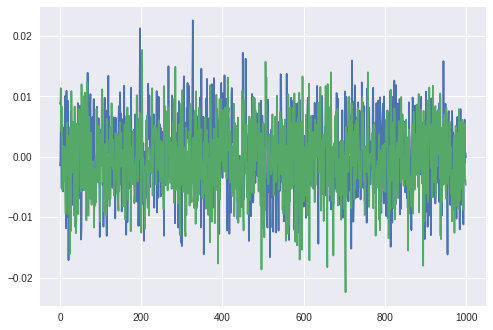

In [3]:
# Plot some of the data
plt.plot(Xd['8PSK', -20][:,1,1]);
plt.plot(Xd['PAM4', -20][:,0,0]);

In [14]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [15]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [21]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()

model.add(Reshape(in_shp+[1], input_shape=in_shp))  # Use for Tensorflow
# model.add(Reshape(in_shp+[1], input_shape=in_shp))  # Use for Theano

model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 132, 80)        0         
__________

In [22]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [25]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
423s - loss: 2.2228 - val_loss: 2.0790
Epoch 2/100
417s - loss: 2.0171 - val_loss: 1.9023
Epoch 3/100
422s - loss: 1.8896 - val_loss: 1.8068
Epoch 4/100
411s - loss: 1.8029 - val_loss: 1.7277
Epoch 5/100
412s - loss: 1.7167 - val_loss: 1.5991
Epoch 6/100
412s - loss: 1.6517 - val_loss: 1.5383
Epoch 7/100
412s - loss: 1.5941 - val_loss: 1.4780
Epoch 8/100
412s - loss: 1.5439 - val_loss: 1.4229
Epoch 9/100
413s - loss: 1.5073 - val_loss: 1.4126
Epoch 10/100
413s - loss: 1.4860 - val_loss: 1.3823
Epoch 11/100
413s - loss: 1.4660 - val_loss: 1.3773
Epoch 12/100
412s - loss: 1.4540 - val_loss: 1.3614
Epoch 13/100
413s - loss: 1.4458 - val_loss: 1.3654
Epoch 14/100
412s - loss: 1.4318 - val_loss: 1.3458
Epoch 15/100
412s - loss: 1.4284 - val_loss: 1.3416
Epoch 16/100
412s - loss: 1.4227 - val_loss: 1.3535
Epoch 17/100
413s - loss: 1.4133 - val_loss: 1.3287
Epoch 18/100
412s - loss: 1.4045 - val_loss: 1.3348
Epoch 19/100
412s - l

# Evaluate and Plot Model Performance

In [27]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

1.27056325599


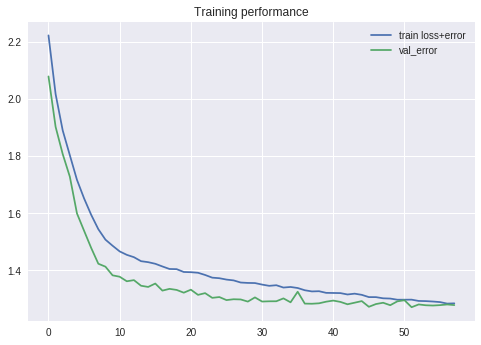

In [28]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [29]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

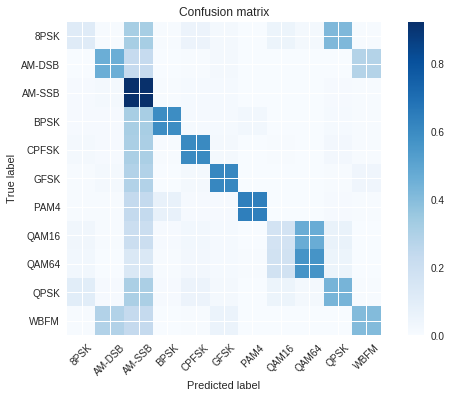

In [30]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.0969807868253
Overall Accuracy:  0.0913714804723
Overall Accuracy:  0.0946092619392
Overall Accuracy:  0.108805485384
Overall Accuracy:  0.134001823154
Overall Accuracy:  0.215745512707
Overall Accuracy:  0.346500091861
Overall Accuracy:  0.50366568915
Overall Accuracy:  0.608133086876
Overall Accuracy:  0.649492017417
Overall Accuracy:  0.699452554745
Overall Accuracy:  0.709014903671
Overall Accuracy:  0.714941262849
Overall Accuracy:  0.730324909747
Overall Accuracy:  0.720288548242
Overall Accuracy:  0.724225865209
Overall Accuracy:  0.715191019374
Overall Accuracy:  0.731684812696
Overall Accuracy:  0.71185520362
Overall Accuracy:  0.729612961296


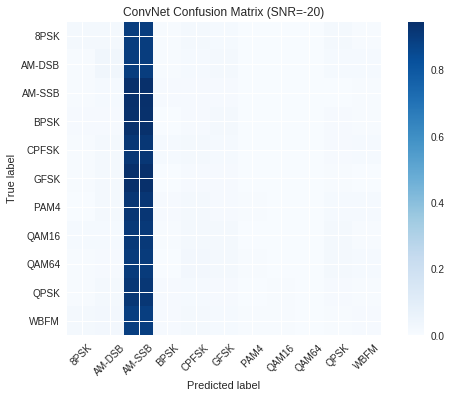

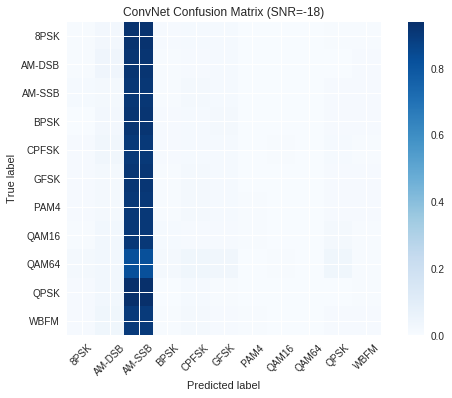

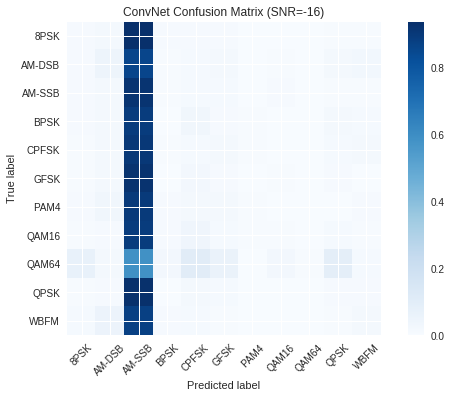

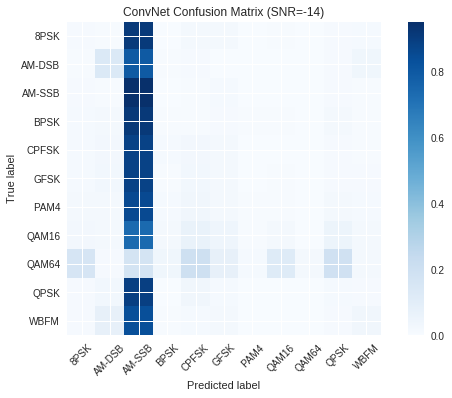

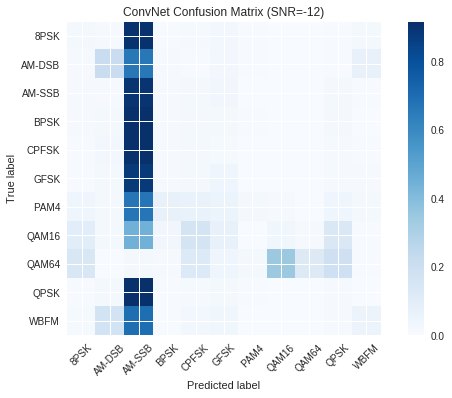

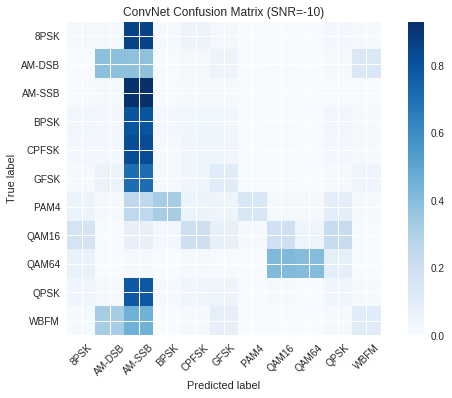

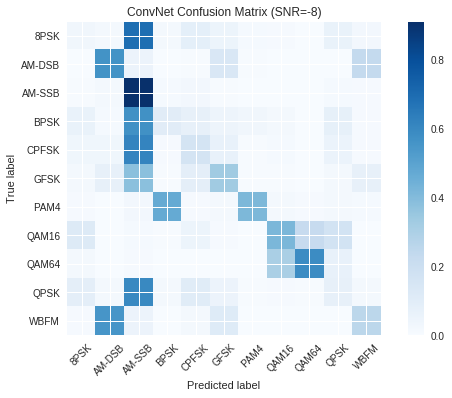

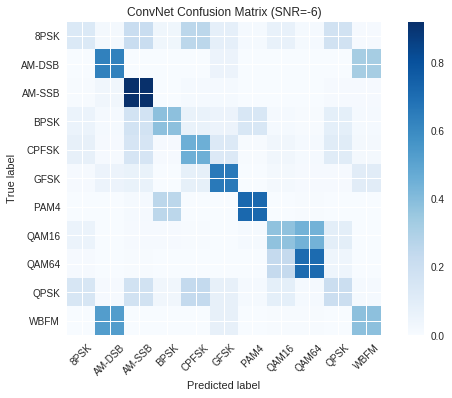

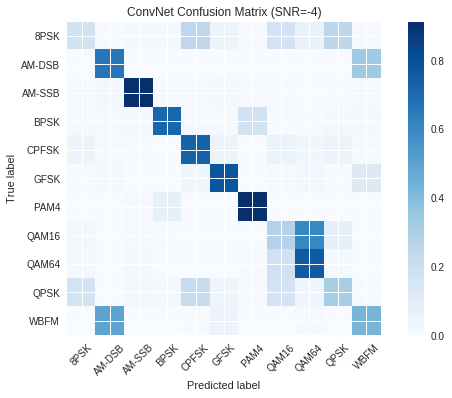

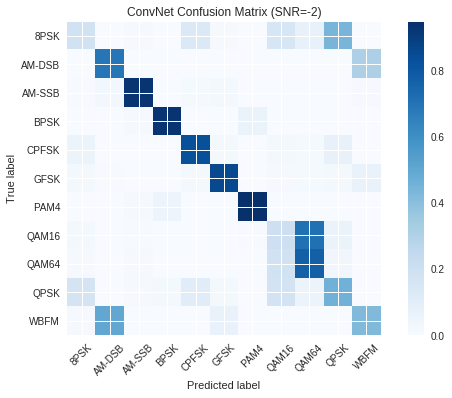

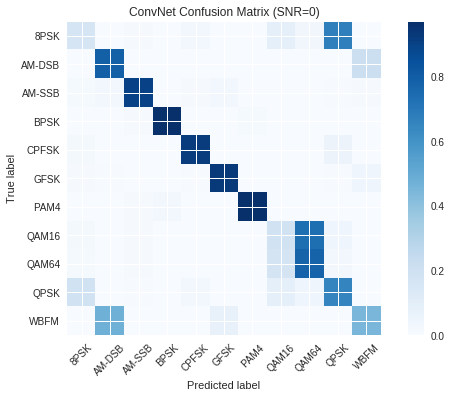

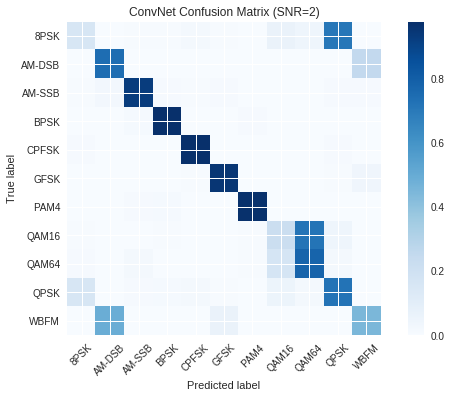

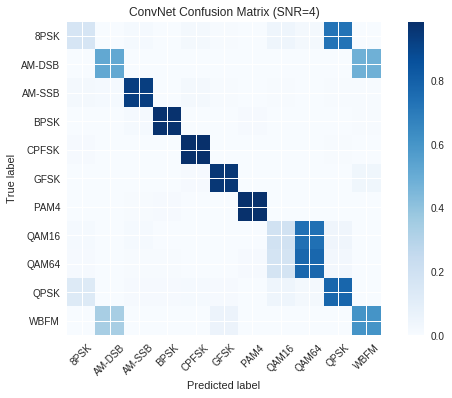

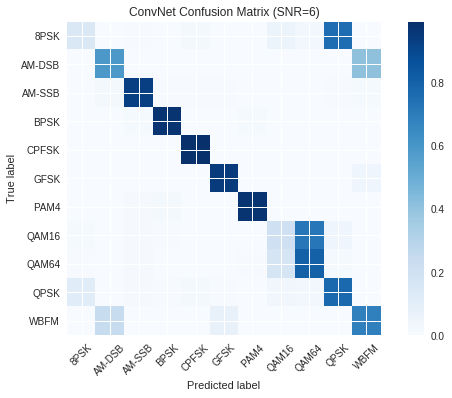

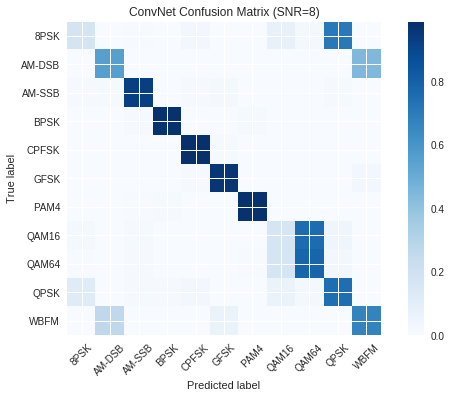

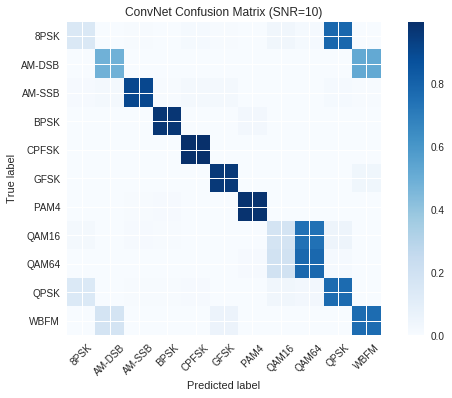

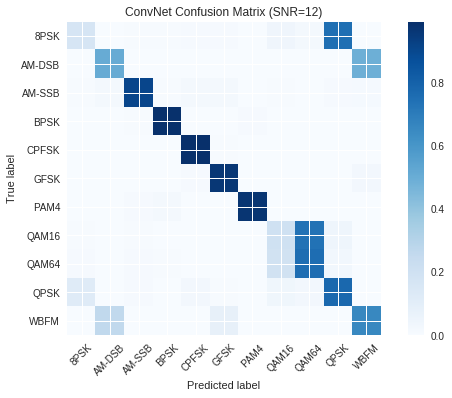

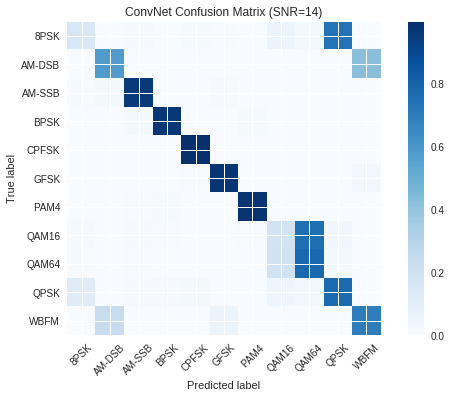

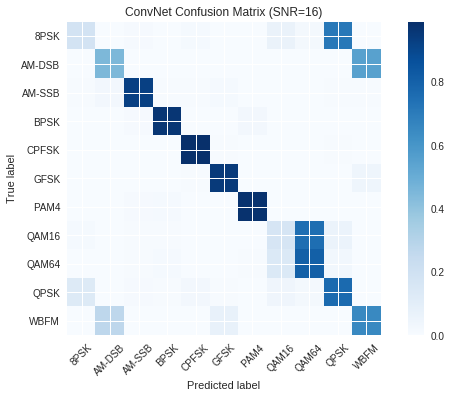

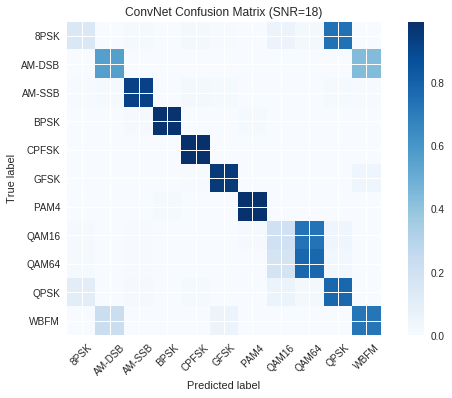

In [31]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [32]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.6994525547445255, 16: 0.7118552036199095, 2: 0.70901490367139219, 4: 0.71494126284875181, 6: 0.73032490974729247, 8: 0.72028854824165911, 12: 0.71519101937352891, 10: 0.72422586520947174, -20: 0.096980786825251603, 18: 0.72961296129612963, -18: 0.091371480472297914, -16: 0.094609261939218522, -14: 0.10880548538433778, -12: 0.13400182315405651, 14: 0.73168481269606933, -10: 0.2157455127065932, -8: 0.34650009186110603, -6: 0.50366568914956011, -4: 0.6081330868761553, -2: 0.64949201741654572}


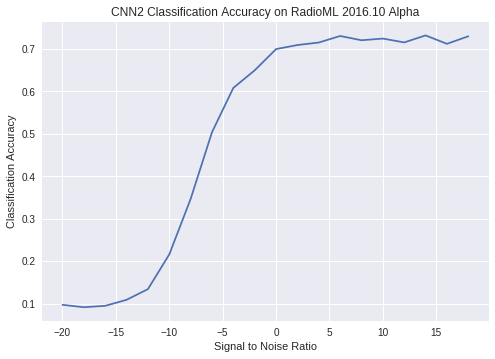

In [34]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");